Current TODO:
- Decide if we are happy with the results
    - They are very different from the values given by graphworld
    - Since GraphWorld's paper they have introduced min_deg which may be weird / influencing the degree distribution
    - num_clusters and min_degree are very low. Are we happy with having a binary classification problem as default? 
    - It may not be intended by GraphWorld, but their integer sampling is not inclusive, hence when we have sampled results for num_clusters from [2-6] then we have really only gotten from [2-5]   
- Discuss biases:
    - Taking the bin with the largest average can be biased if one property produces an extremely large value while the remaining properties produce small values (see results for avg_deg)
    - Certain models may affect the results, as for each graph we examine the average test metric across all methods. If 1 method behaves produces extreme values while the remaining only differ very little, then the models with extreme values will have a larger influence in our results

In [1]:
import pandas as pd
import json
from evaluation_utils import read_processed_shards, get_best_configuration_per_model
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.ticker import PercentFormatter
from scipy.stats import f_oneway
from tqdm import tqdm
from collections import defaultdict
import scipy

In [2]:
PROCESSED_DIR = f'results/mode1/processed'
df = read_processed_shards(PROCESSED_DIR)

1.ndjson
2.ndjson
3.ndjson
4.ndjson
5.ndjson
6.ndjson
7.ndjson
8.ndjson
9.ndjson
10.ndjson
11.ndjson
concatenating


In [3]:
# Remove graphs where at least one method have failed
df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
df.dropna(axis=0, inplace=True)
df.reset_index(inplace = True, drop=True)

### Computing default graph properties given all experiments no matter the model configuration

In [4]:
# Compute average test metric for each graph for all GNN (no matter the configuration)
TEST_METRIC = 'test_rocauc_ovr'
cols = [col for col in df.columns if TEST_METRIC in col]
df[f'avg_{TEST_METRIC}'] = df[cols].mean(axis=1)

In [13]:
def find_default_graph_properties(data, BINS = 40):
    # ---------------- SETUP ----------------
    # Bin each graph property into a fixed number of quantile bines
    GRAPH_PROPERTIES = ['nvertex', 'avg_degree', 'feature_center_distance', 'num_clusters',
                        'cluster_size_slope', 'power_exponent', 'p_to_q_ratio', 'min_deg']
    for gp in GRAPH_PROPERTIES:
        if len(data[gp].unique()) < BINS: # If graph property has small samples, create bins centered on each integer value
            bin_edges = [b - 0.5 for b in sorted(data[gp].unique())] + [data[gp].max() + 0.5]
            bins = pd.cut(data[gp], bins=bin_edges)
        else:
            bins = pd.qcut(data[gp], q=BINS, duplicates='drop')
        data[f'bin_{gp}'] = bins

    # create an empty dictionary to store the results
    results = {}

    # Plotting setup
    colors = {}
    for i, gp in enumerate(GRAPH_PROPERTIES):
        colors[gp] = plt.cm.tab10(i)

    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,5))



    # ---------------- EXECUTION ----------------
    # loop over each graph property
    for gp, ax in zip(GRAPH_PROPERTIES, axs.reshape(-1)):
        bin_f_stats = {}
        plotting_f_stats = defaultdict(list)
        bins = sorted(data[f'bin_{gp}'].unique())

        # loop over each quantile bin of the property
        for b in bins:
            # filter the dataframe to only include rows where the current parameter is in bin i
            data_i = data[data[f'bin_{gp}'] == b]

            # compute the average F statistic between the other parameters and the test metric
            f_stats = []
            for gp_other in GRAPH_PROPERTIES:
                if gp_other != gp:
                    groups = list(data_i.groupby(f'bin_{gp_other}')[f'avg_{TEST_METRIC}'].apply(list)) # Create a group per bin
                    groups = [g for g in groups if len(g) > 0] # Remove empty groups 
                    f_stat, p_val = f_oneway(*groups)
                    f_stats.append(f_stat)
                    plotting_f_stats[gp_other].append(f_stat)        
            bin_f_stats[b] = sum(f_stats) / len(f_stats)

        # find the quantized value that produced the highest average F statistic
        max_f_stat = max(bin_f_stats, key=bin_f_stats.get)
        results[gp] = max_f_stat

        # plotting
        for k,v in plotting_f_stats.items():
            ax.scatter([b.mid for b in bins], v, color=colors[k], label=k, s=10)
        ax.axvline(x = max_f_stat.mid, color = 'black', label = 'chosen bin', linestyle='dashed')
        ax.plot([b.mid for b in bins], [f for f in bin_f_stats.values()], color='black', label="average f stat")
        ax.title.set_text(gp)
    axs[-1][-1].legend(bbox_to_anchor=(1.1, 1.05))
    fig.tight_layout()
    plt.show()
            
    for k,v in results.items():
        print(f'Optimal {k} bin: {v}, mid: {v.mid}')

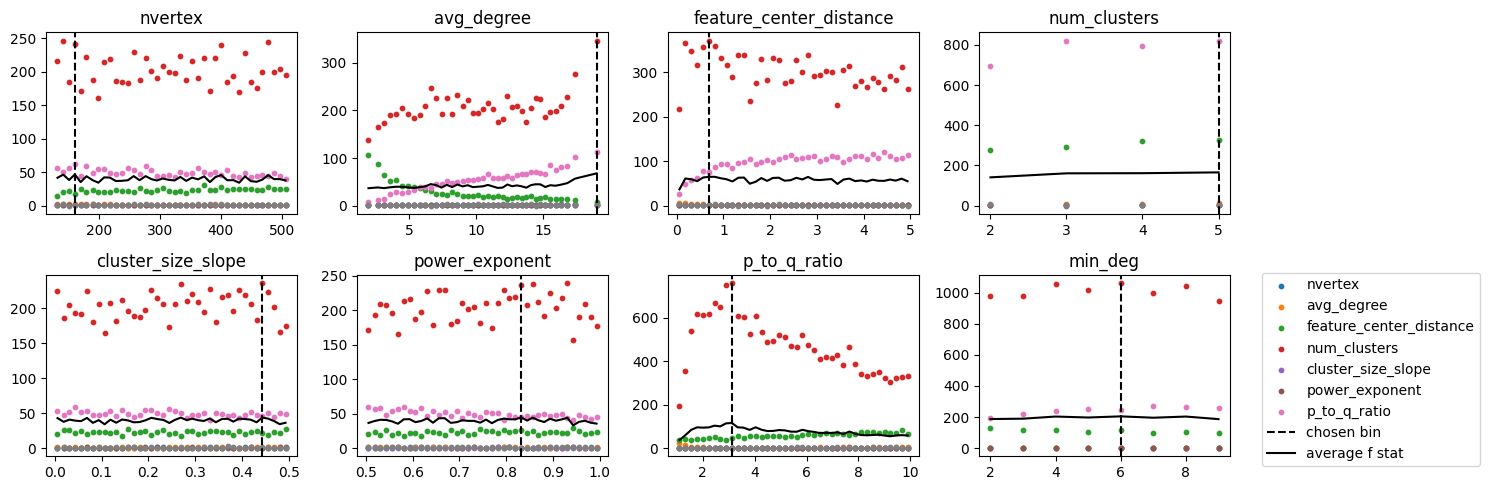

Optimal nvertex bin: (156.0, 166.0], mid: 161.0
Optimal avg_degree bin: (17.745, 20.289], mid: 19.017000000000003
Optimal feature_center_distance bin: (0.63, 0.754], mid: 0.692
Optimal num_clusters bin: (4.5, 5.5], mid: 5.0
Optimal cluster_size_slope bin: (0.438, 0.45], mid: 0.444
Optimal power_exponent bin: (0.826, 0.839], mid: 0.8325
Optimal p_to_q_ratio bin: (3.018, 3.238], mid: 3.128
Optimal min_deg bin: (5.5, 6.5], mid: 6.0


In [14]:
find_default_graph_properties(df)

### Computing default graph properties given experiments that only has sampled the best model configuration

In [7]:
# Get the best average configuration per model
TEST_METRIC = 'test_rocauc_ovr'

df2 = df.copy()
df2.drop([f'avg_{TEST_METRIC}'], axis=1, inplace=True)
df2.reset_index(inplace=True)
best_configurations = get_best_configuration_per_model(df2, TEST_METRIC)

In [8]:
# Computes the average test metric of all graphs by 
# only considering the methods which has been sampled in their best configuration
# - If no best configuration for any method has been sampled for a graph, we remove the graph from the evaluation
df2['methods_with_best_configuration'] = 0
df2[f'avg_{TEST_METRIC}'] = 0.0
for model, configuration in best_configurations.items():
    configuration.drop([f'{model}_{TEST_METRIC}'], axis=1, inplace=True, errors='ignore')
    graphs_with_configuration = df2.merge(configuration).set_index('index')
    df2.loc[graphs_with_configuration.index, f'avg_{TEST_METRIC}'] += \
        df2.loc[graphs_with_configuration.index, f'{model}_{TEST_METRIC}']
    df2.loc[graphs_with_configuration.index, 'methods_with_best_configuration'] += 1
df2 = df2[df2['methods_with_best_configuration'] > 0]
df2[f'avg_{TEST_METRIC}'] /= df2['methods_with_best_configuration']

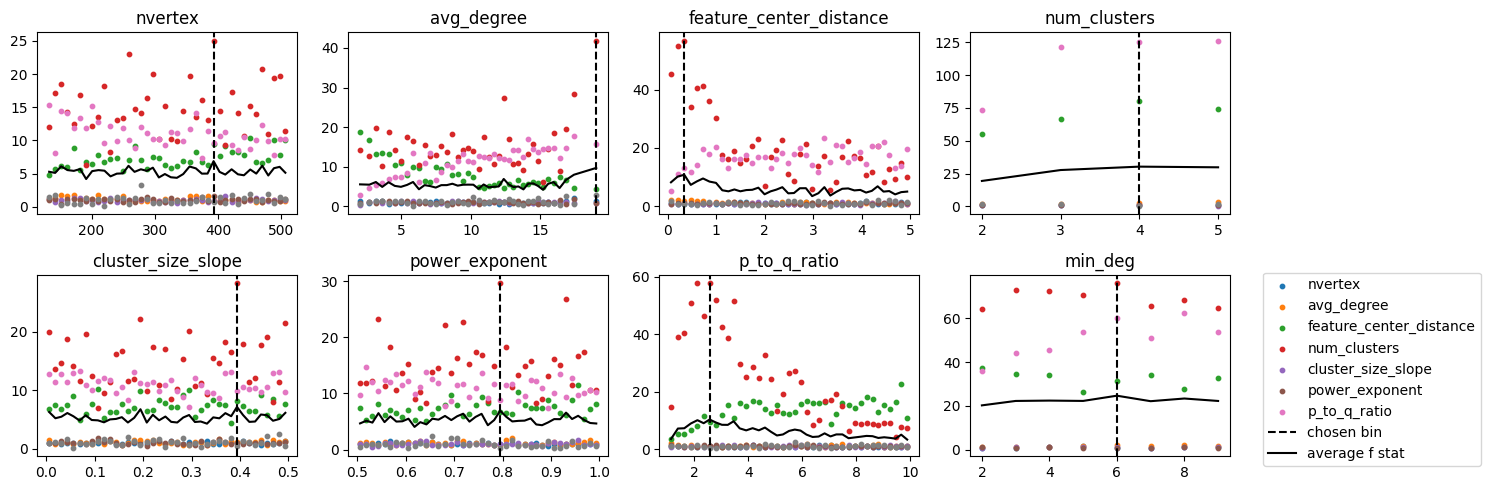

Optimal nvertex bin: (388.0, 398.0], mid: 393.0
Optimal avg_degree bin: (17.752, 20.288], mid: 19.02
Optimal feature_center_distance bin: (0.274, 0.412], mid: 0.34299999999999997
Optimal num_clusters bin: (3.5, 4.5], mid: 4.0
Optimal cluster_size_slope bin: (0.388, 0.4], mid: 0.394
Optimal power_exponent bin: (0.789, 0.801], mid: 0.795
Optimal p_to_q_ratio bin: (2.457, 2.675], mid: 2.566
Optimal min_deg bin: (5.5, 6.5], mid: 6.0


In [15]:
find_default_graph_properties(df2)